In [ ]:
# for Colab
!pip install botorch

In [2]:
import torch
import botorch
import gpytorch

from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double # double == float64

# isn't this easier?
# https://github.com/pytorch/botorch/discussions/1444
torch.set_default_dtype(dtype)

# torch.set_default_device(device) # similarly

import numpy as np
import matplotlib.pyplot as plt

from generate_gp_data import GaussainProcessRandomDataset, FunctionSamplesDataset, TrainAcquisitionFunctionDataset, pad_tensor
from predict_EI_simple import calculate_EI_GP
from utils import get_uniform_randint_generator, loguniform_randint, get_loguniform_randint_generator


/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


likelihood.noise_covar.raw_noise Parameter containing:
tensor([1.0000e-06], requires_grad=True)

mean_module.raw_constant Parameter containing:
tensor(0., requires_grad=True)

covar_module.raw_outputscale Parameter containing:
tensor(0., requires_grad=True)

covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[0.]], requires_grad=True)

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([1.0000e-06])), ('likelihood.noise_covar.raw_noise_constraint.lower_bound', tensor(0.)), ('likelihood.noise_covar.raw_noise_constraint.upper_bound', tensor(inf)), ('mean_module.raw_constant', tensor(0.)), ('covar_module.raw_outputscale', tensor(0.)), ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])), ('covar_module.base_kernel.lengthscale_prior.concentration', tensor(3.)), ('covar_module.base_kernel.lengthscale_prior.rate', tensor(6.)), ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound', tensor(0.)), ('covar_module.base_kernel.raw_lengthscale_constrain

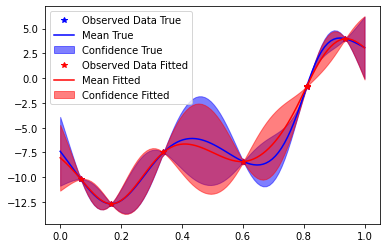

In [3]:
# randint_gen = get_uniform_randint_generator(4, 20)
# dataset = GaussainProcessRandomDataset(
#     dimension=1, n_datapoints_random_gen=randint_gen, observation_noise=False,
#     device=device)

# torch.manual_seed(1703)

OBSERVATION_NOISE = False

dataset = GaussainProcessRandomDataset(
    dimension=1, n_datapoints=7, observation_noise=OBSERVATION_NOISE,
    set_random_model_train_data=True, device=device)

for name, param in dataset.model_sampler.get_model(0).named_parameters(): 
    print(name, param)
    print()

print(dataset.model_sampler.get_model(0).state_dict())

x_values, y_values, model = next(dataset)

true_lengthscale = model.covar_module.base_kernel.lengthscale.squeeze().detach().numpy()
true_outputscale = model.covar_module.outputscale.squeeze().detach().numpy()
true_noise = model.likelihood.noise_covar.raw_noise.squeeze().detach().numpy()

test_x = torch.linspace(0, 1, 100, device=device)

# Get posterior under true model parameters
posterior_true = model.posterior(test_x, observation_noise=OBSERVATION_NOISE)


for name, param in model.named_parameters(): 
    print(name, param)
    print()


# Get posterior by fitting by MAP
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
posterior_fitted = model.posterior(test_x, observation_noise=OBSERVATION_NOISE)
fitted_model = model

fitted_lengthscale = fitted_model.covar_module.base_kernel.lengthscale.squeeze().detach().numpy()
fitted_outputscale = fitted_model.covar_module.outputscale.squeeze().detach().numpy()
fitted_noise = fitted_model.likelihood.noise_covar.raw_noise.squeeze().detach().numpy()


with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    description_true   = f'True:   l={  true_lengthscale:.3g}, sigma^2={  true_outputscale:.3g}, noise={true_noise:.3g}'
    description_fitted = f'Fitted: l={fitted_lengthscale:.3g}, sigma^2={fitted_outputscale:.3g}, noise={fitted_noise:.3g}'
    print(description_true)
    print(description_fitted)
    
    plot_gp_posterior(ax, posterior_true, test_x, x_values, y_values, 'b', name='True')
    plot_gp_posterior(ax, posterior_fitted, test_x, x_values, y_values, 'r', name='Fitted')

    ax.legend()

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


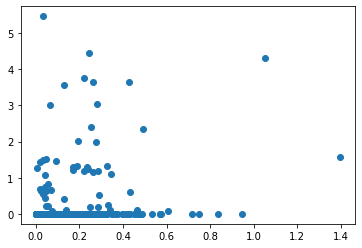

In [6]:
# import cProfile, pstats, io
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()


OBSERVATION_NOISE = False
dataset = GaussainProcessRandomDataset(
    dimension=5, n_datapoints=20, observation_noise=OBSERVATION_NOISE,
    set_random_model_train_data=False, device=device)

n_samples = 1000

ei_values = torch.empty(n_samples, device=device)
improvement_values = torch.empty(n_samples, device=device)


with torch.no_grad():
    for i in range(n_samples):
        x_values, y_values, random_model = next(dataset)

        # x_values is shape (n_datapoints, dimension)
        # y_values is shape (n_datapoints,)
        x_hist = x_values[:-1, :]
        y_hist = y_values[:-1]
        x = x_values[-1:, :]
        y = y_values[-1:]
        
        ei_value, improvement_value = calculate_EI_GP(random_model, x_hist, y_hist, x, y, fit_params=False)
        ei_values[i] = ei_value[0]
        improvement_values[i] = improvement_value[0]

    # print(ei_values)
    # print(improvement_values)


# pr.disable()
# s = io.StringIO()
# sortby = SortKey.CUMULATIVE
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

plt.scatter(ei_values.cpu().numpy(), improvement_values.cpu().numpy())

In [29]:
class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, start, end):
        super(MyIterableDataset).__init__()
        assert end > start, "this example code only works with end >= start"
        self.start = start
        self.end = end

    def __iter__(self):
        return iter(range(self.start, self.end))

for x in MyIterableDataset(3, 7):
    print(x)


3
4
5
6


In [36]:
u = torch.rand(8, 3)
print(u)
rand_indices = torch.randperm(u.shape[0])
print(rand_indices)
print(u[rand_indices])
print(u[rand_indices[:3]])
print(u[rand_indices[3:]])

tensor([[0.4321, 0.9570, 0.2413],
        [0.7917, 0.6027, 0.1502],
        [0.7692, 0.3887, 0.8973],
        [0.2957, 0.0481, 0.0261],
        [0.6843, 0.2177, 0.8816],
        [0.1277, 0.4359, 0.3886],
        [0.0205, 0.9009, 0.2009],
        [0.2266, 0.2300, 0.7466]])
tensor([2, 6, 5, 4, 3, 0, 7, 1])
tensor([[0.7692, 0.3887, 0.8973],
        [0.0205, 0.9009, 0.2009],
        [0.1277, 0.4359, 0.3886],
        [0.6843, 0.2177, 0.8816],
        [0.2957, 0.0481, 0.0261],
        [0.4321, 0.9570, 0.2413],
        [0.2266, 0.2300, 0.7466],
        [0.7917, 0.6027, 0.1502]])
tensor([[0.7692, 0.3887, 0.8973],
        [0.0205, 0.9009, 0.2009],
        [0.1277, 0.4359, 0.3886]])
tensor([[0.6843, 0.2177, 0.8816],
        [0.2957, 0.0481, 0.0261],
        [0.4321, 0.9570, 0.2413],
        [0.2266, 0.2300, 0.7466],
        [0.7917, 0.6027, 0.1502]])


In [45]:
q = torch.rand(20)
q - 10.0

tensor([-9.5747, -9.7501, -9.6260, -9.5177, -9.1595, -9.5724, -9.6298, -9.1459,
        -9.6044, -9.6240, -9.6702, -9.5881, -9.5899, -9.7063, -9.1460, -9.7534,
        -9.3527, -9.5060, -9.5050, -9.8674])

In [48]:
type(dataset)

predict_EI_simple.GaussainProcessRandomDataset

In [50]:
list[dict]

list[dict]

In [49]:
isinstance(dataset, torch.utils.data.IterableDataset)

True

In [53]:
dataset.__class__.__name__

'GaussainProcessRandomDataset'

In [58]:
{x:y for x, y in model.named_parameters()}

{'likelihood.noise_covar.raw_noise': Parameter containing:
 tensor([0.], requires_grad=True),
 'mean_module.raw_constant': Parameter containing:
 tensor(0.0074, requires_grad=True),
 'covar_module.raw_outputscale': Parameter containing:
 tensor(14.9644, requires_grad=True),
 'covar_module.base_kernel.raw_lengthscale': Parameter containing:
 tensor([[0.8065]], requires_grad=True)}

In [59]:
{x:y.detach() for x, y in model.named_parameters()}

{'likelihood.noise_covar.raw_noise': tensor([0.]),
 'mean_module.raw_constant': tensor(0.0074),
 'covar_module.raw_outputscale': tensor(14.9644),
 'covar_module.base_kernel.raw_lengthscale': tensor([[0.8065]])}

In [22]:
model.index

0

In [26]:
fixed_dataset = FunctionSamplesDataset.from_gp_random_dataset(dataset, 1000)
fixed_dataset.save("data")

In [30]:
fixed_dataset[0][0]

tensor([[0.8489, 0.1965, 0.0284, 0.0234, 0.1666],
        [0.8518, 0.9975, 0.9318, 0.0532, 0.1928],
        [0.9660, 0.5656, 0.1563, 0.1609, 0.0425],
        [0.4375, 0.4648, 0.2420, 0.1713, 0.9196],
        [0.0546, 0.8694, 0.4443, 0.5036, 0.8704],
        [0.9682, 0.4215, 0.7049, 0.4719, 0.8775],
        [0.6631, 0.9408, 0.6663, 0.5284, 0.6014],
        [0.8294, 0.9148, 0.5544, 0.8021, 0.8817],
        [0.7465, 0.8460, 0.5765, 0.1917, 0.8225],
        [0.2578, 0.8584, 0.0147, 0.4841, 0.8581],
        [0.8904, 0.7481, 0.0781, 0.5039, 0.5400],
        [0.1587, 0.6665, 0.6906, 0.8259, 0.9701],
        [0.1105, 0.4084, 0.0324, 0.1800, 0.1766],
        [0.9080, 0.4782, 0.8625, 0.7269, 0.8146],
        [0.5159, 0.9522, 0.1116, 0.6569, 0.7407],
        [0.7568, 0.2690, 0.5293, 0.2926, 0.5500],
        [0.6386, 0.7783, 0.5267, 0.3157, 0.0216],
        [0.3528, 0.7596, 0.1990, 0.9174, 0.3976],
        [0.2512, 0.9899, 0.4709, 0.1600, 0.5643],
        [0.7841, 0.6821, 0.1907, 0.4530, 0.0499]])

In [33]:
fixed_dataset_loaded = FunctionSamplesDataset.load("data")
fixed_dataset_loaded[0][2].index

0

In [12]:
test_dataset = FunctionSamplesDataset([
    {'x_values': [i], 
     'y_values': [i]}
     for i in range(20)
] + [{'x_values': [12, 13], 'y_values': [33]}])

# test_dataset = GaussainProcessRandomDataset(
#     dimension=2, n_datapoints=4, observation_noise=OBSERVATION_NOISE,
#     set_random_model_train_data=False, device=device)


data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None,
                                        #   sampler=torch.utils.data.RandomSampler(test_dataset, replacement=False, num_samples=200)
                                          )

for x in test_dataset:
    print(x)




([0], [0])
([1], [1])
([2], [2])
([3], [3])
([4], [4])
([5], [5])
([6], [6])
([7], [7])
([8], [8])
([9], [9])
([10], [10])
([11], [11])
([12], [12])
([13], [13])
([14], [14])
([15], [15])
([16], [16])
([17], [17])
([18], [18])
([19], [19])
([12, 13], [33])


In [8]:
class FirstNIterable:
    def __init__(self, iterable, n):
        self.iterable = iterable
        self.n = n
    
    def __iter__(self):
        iterator = iter(self.iterable)
        for _ in range(self.n):
            try:
                yield next(iterator)
            except StopIteration:
                break

first3 = FirstNIterable(test_dataset, 3)
first5 = FirstNIterable(first3, 5)
for a,b,c in first5:
    print(b)

tensor([-3.8186, -0.1947, -4.2731, -4.8191])
tensor([2.0626, 1.2860, 3.2079, 2.8453])
tensor([-1.4478, -2.5589,  0.8257,  0.8572])


In [37]:
hasattr(test_dataset, '_model_sampler')

False

In [9]:
words = ["apple", "banana", "cherry", "date"]
first_two = FirstNIterable(words, 2)
list(first_two)

['apple', 'banana']

In [10]:
numbers = range(10)
first_five = FirstNIterable(numbers, 5)
list(first_five)

[0, 1, 2, 3, 4]

In [2]:
rand_dataset = GaussainProcessRandomDataset(n_datapoints=15, dimension=5)
function_samples_dataset = FunctionSamplesDataset.from_gp_random_dataset(rand_dataset, 100)
function_samples_dataset.save('test')
loaded_dataset = FunctionSamplesDataset.load('test')

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


In [3]:
function_samples_dataset_2 = FunctionSamplesDataset.from_gp_random_dataset(function_samples_dataset, 100)

In [ ]:
loaded_dataset[0][2]

In [ ]:
function_samples_dataset_2[0][2]

In [12]:
from collections.abc import Sequence
import numpy as np
print(isinstance([1, 2, 3], Sequence))
print(isinstance((1,2,3), Sequence))
print(isinstance(np.array([1,5,5]), Sequence))

True
True
False


In [6]:
len(np.array([1,5,5]))

3

In [8]:
np.array([1,5,5])[0]

1

In [9]:
qq = [1]
try:
    a = qq[1]
except TypeError:
    print("IndexError")

IndexError


In [39]:
import torch
int(torch.distributions.Binomial(10, 0.5).sample())

4

In [3]:
from generate_gp_data import GaussainProcessRandomDataset, FunctionSamplesDataset, TrainAcquisitionFunctionDataset

N_CANDIDATES = 30
MAX_HISTORY = 70
HISTORY_LOGUNIFORM = True

if HISTORY_LOGUNIFORM:
    randint_gen = get_loguniform_randint_generator(
        1, MAX_HISTORY, pre_offset=3.0, offset=N_CANDIDATES)
else:
    randint_gen = get_uniform_randint_generator(
        N_CANDIDATES+1, N_CANDIDATES+MAX_HISTORY)

dataset = GaussainProcessRandomDataset(
    dimension=6, n_datapoints_random_gen=randint_gen, observation_noise=False,
    set_random_model_train_data=False, device=device)
# dataset = FunctionSamplesDataset.from_gp_random_dataset(dataset, 100)

print(dataset)

training_dataset = TrainAcquisitionFunctionDataset(
    dataset, dataset_size=100, n_candidate_points=N_CANDIDATES, n_samples="all", give_improvements=True, min_n_candidates=2)

for x_hist, y_hist, x_cand, improvements, model in training_dataset:
    print(x_hist.shape, y_hist.shape, x_cand.shape, improvements.shape)


/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


torch.Size([6, 6]) torch.Size([6]) torch.Size([30, 6]) torch.Size([30])
torch.Size([5, 6]) torch.Size([5]) torch.Size([30, 6]) torch.Size([30])
torch.Size([35, 6]) torch.Size([35]) torch.Size([30, 6]) torch.Size([30])
torch.Size([20, 6]) torch.Size([20]) torch.Size([30, 6]) torch.Size([30])
torch.Size([11, 6]) torch.Size([11]) torch.Size([30, 6]) torch.Size([30])
torch.Size([8, 6]) torch.Size([8]) torch.Size([30, 6]) torch.Size([30])
torch.Size([2, 6]) torch.Size([2]) torch.Size([30, 6]) torch.Size([30])
torch.Size([2, 6]) torch.Size([2]) torch.Size([30, 6]) torch.Size([30])
torch.Size([17, 6]) torch.Size([17]) torch.Size([30, 6]) torch.Size([30])
torch.Size([3, 6]) torch.Size([3]) torch.Size([30, 6]) torch.Size([30])
torch.Size([33, 6]) torch.Size([33]) torch.Size([30, 6]) torch.Size([30])
torch.Size([16, 6]) torch.Size([16]) torch.Size([30, 6]) torch.Size([30])
torch.Size([1, 6]) torch.Size([1]) torch.Size([30, 6]) torch.Size([30])
torch.Size([16, 6]) torch.Size([16]) torch.Size([30,

In [8]:
%load_ext autoreload
%autoreload 2

In [6]:
%aimport generate_gp_data

In [23]:
data_loader = training_dataset.get_dataloader(batch_size=4)

for x_hist, y_hist, x_cand, improvements, model in data_loader:
    print(x_hist.shape, y_hist.shape, x_cand.shape, improvements.shape)

torch.Size([4, 23, 6]) torch.Size([4, 23]) torch.Size([4, 30, 6]) torch.Size([4, 30])
torch.Size([4, 64, 6]) torch.Size([4, 64]) torch.Size([4, 30, 6]) torch.Size([4, 30])
torch.Size([4, 13, 6]) torch.Size([4, 13]) torch.Size([4, 30, 6]) torch.Size([4, 30])
torch.Size([4, 32, 6]) torch.Size([4, 32]) torch.Size([4, 30, 6]) torch.Size([4, 30])
torch.Size([4, 65, 6]) torch.Size([4, 65]) torch.Size([4, 30, 6]) torch.Size([4, 30])
torch.Size([4, 46, 6]) torch.Size([4, 46]) torch.Size([4, 30, 6]) torch.Size([4, 30])
torch.Size([4, 32, 6]) torch.Size([4, 32]) torch.Size([4, 30, 6]) torch.Size([4, 30])
torch.Size([4, 58, 6]) torch.Size([4, 58]) torch.Size([4, 30, 6]) torch.Size([4, 30])
torch.Size([4, 14, 6]) torch.Size([4, 14]) torch.Size([4, 30, 6]) torch.Size([4, 30])
torch.Size([4, 45, 6]) torch.Size([4, 45]) torch.Size([4, 30, 6]) torch.Size([4, 30])
torch.Size([4, 53, 6]) torch.Size([4, 53]) torch.Size([4, 30, 6]) torch.Size([4, 30])
torch.Size([4, 38, 6]) torch.Size([4, 38]) torch.Size(

In [11]:
data = torch.randn(4, 3)
padded = pad_tensor(data, 6, dim=0, add_mask=True)
padded

MaskedTensor(
  [
    [ -2.0264,  -0.1255,   1.0940],
    [ -0.4569,   0.0726,  -1.6931],
    [  0.7914,  -1.1888,  -0.1016],
    [ -0.4038,  -0.5596,  -0.1056],
    [      --,       --,       --],
    [      --,       --,       --]
  ]
)

In [ ]:
from torch.masked import masked_tensor

data = torch.arange(24).reshape(2, 3, 4).float()
mask = data % 2 == 0

print("data:\n", data)
print(f"mask: {mask.dtype}\n", mask)
mt = masked_tensor(data, mask)
print("data masked:\n", mt)

data2 = torch.randn(2, 3, 4)
mt2 = masked_tensor(data2, mask)
print("data2 masked:\n", mt2)

stacked_masked = torch.vstack([mt, mt2])
print("stacked_masked:\n", stacked_masked)


(array([ 40.,   0.,   0.,   0.,   0.,   0.,  37.,   0.,   0.,   0.,  28.,
          0.,   0.,  28.,   0.,   0.,  35.,  28.,   0.,  28.,  38.,  32.,
          0.,  71.,  34.,  31.,  28.,  67.,  64.,  73.,  53.,  68., 110.,
        101.,  95.,  94., 154., 121., 170., 171., 215., 195., 237., 297.,
        324., 303., 384., 381., 431., 454., 524., 561., 659., 683., 762.,
        861., 930.]),
 array([0.        , 0.10006636, 0.20013272, 0.30019908, 0.40026544,
        0.5003318 , 0.60039816, 0.70046451, 0.80053087, 0.90059723,
        1.00066359, 1.10072995, 1.20079631, 1.30086267, 1.40092903,
        1.50099539, 1.60106175, 1.70112811, 1.80119447, 1.90126082,
        2.00132718, 2.10139354, 2.2014599 , 2.30152626, 2.40159262,
        2.50165898, 2.60172534, 2.7017917 , 2.80185806, 2.90192442,
        3.00199078, 3.10205714, 3.20212349, 3.30218985, 3.40225621,
        3.50232257, 3.60238893, 3.70245529, 3.80252165, 3.90258801,
        4.00265437, 4.10272073, 4.20278709, 4.30285345, 4.402919

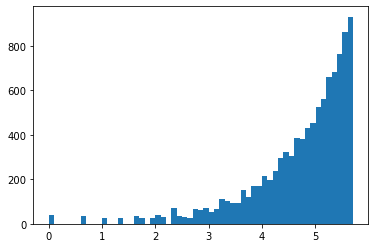

In [44]:
min_val = 1
max_val = 300
vals = torch.randint(min_val, max_val+1, (10_000,), dtype=torch.float64)

data = torch.log(vals).numpy()
plt.hist(data, bins='auto')

In [51]:
from torch.distributions import Uniform
m = Uniform(torch.tensor(0.0), torch.tensor(5.0))
m.sample

<bound method Distribution.sample of Uniform(low: 0.0, high: 5.0)>

In [54]:
torch.as_tensor(3, dtype=torch.float64)

tensor(3.)

In [55]:
torch.as_tensor(3).to(dtype=torch.float64)

tensor(3.)

In [60]:
torch.as_tensor(3).to(dtype=torch.int32).dtype

torch.int32

In [76]:
torch.log(torch.tensor(9813))

tensor(9.1915)

In [87]:
int(torch.exp(torch.rand(1)).item())

2

In [92]:
torch.exp(torch.rand(10)).to(dtype=torch.int32) + 44

tensor([45, 46, 46, 45, 45, 45, 45, 45, 45, 46], dtype=torch.int32)

In [224]:

vals = loguniform_randint(1, 1000, 1000, pre_offset=15.0)
print(vals)

# fig = plt.figure()
# ax = fig.add_subplot(2, 1, 1)
# ax.hist(vals.numpy(), bins=500)
# ax.set_xscale('log')

tensor([300, 476,  12,  28,   8,  52,  98, 758, 881, 199, 176,  58,  11, 119,
        164, 848, 173, 306,   6, 924,   3, 386,  15,  70, 565,   9, 149, 880,
          7,  12,  51, 154, 177, 119,  39, 134,  87,   3, 143,  31,  31, 123,
          2, 258, 957,  12, 113, 338, 393,  92,  41,  54,  22,  47, 170, 972,
         15, 516,  41, 369,  57,  15, 383, 546,  79,  64,  12,  25,  71, 105,
          9,  22,  92,  12,  31, 583, 111,  12, 571,  21,  49, 854, 329, 884,
        238, 704, 116, 640, 125,  63, 145, 437,  73,   5, 917,   5,  98,  11,
         37,   1,  82, 993,  71, 425, 712, 176, 121,  40, 776,  75, 133, 210,
        209, 254, 535,  72, 451,   3, 710,  99, 582, 237,   9, 705, 509, 207,
         56,  79,  53, 223,  13, 862, 292,  94, 562,  18,  15, 923,   2, 473,
        293,  10, 229, 100, 129,  77,  30,  69, 242, 721, 956,  23,  32,  17,
         10,  41, 721,   4, 378,  55,  45, 354, 121, 288, 120, 322,  33, 969,
         43,  74, 146,  16,  30,  86,  24, 422,  86,   5,   6,  

In [123]:
0 + 0.0

0.0

In [6]:
x = torch.randn(2, 3)
x

tensor([[-0.7867, -0.2701,  0.1800],
        [-0.4704, -0.5729, -0.2115]])

In [9]:
pad_tensor(x, 2, 1)

tensor([[-0.7867, -0.2701,  0.1800],
        [-0.4704, -0.5729, -0.2115]])

In [3]:
w = torch.randn(7, 3)
torch.cat((w, w), dim=0)

tensor([[ 0.7351,  2.2052, -0.1024],
        [ 0.3160,  1.1978, -1.0705],
        [ 0.0312, -0.9250,  0.6934],
        [ 0.6693,  0.9474,  0.6085],
        [ 0.5895,  0.2485, -0.2172],
        [-0.6764,  2.4663, -0.7710],
        [ 0.1756,  0.0874, -0.2661],
        [ 0.7351,  2.2052, -0.1024],
        [ 0.3160,  1.1978, -1.0705],
        [ 0.0312, -0.9250,  0.6934],
        [ 0.6693,  0.9474,  0.6085],
        [ 0.5895,  0.2485, -0.2172],
        [-0.6764,  2.4663, -0.7710],
        [ 0.1756,  0.0874, -0.2661]])

In [61]:
u = list(w.shape)
pad_shape = list(w.shape)
pad_shape[0] = 10
padding = torch.zeros(*pad_shape, dtype=w.dtype, device=w.device)
padded = torch.cat([w, padding], dim=0)
padded

tensor([[ 1.0335, -1.5776, -0.1009],
        [-1.4248,  0.2405, -0.1990],
        [-1.5726, -0.2506,  0.8141],
        [-0.5141,  0.7484, -0.5117],
        [-2.6152, -0.0900, -1.0199],
        [-1.2312, -0.2395, -0.3144],
        [-1.1721,  1.2124, -1.7637],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [4]:
masked = pad_tensor(w, length=10, dim=0, add_mask=True)
masked

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


MaskedTensor(
  [
    [  0.7351,   2.2052,  -0.1024],
    [  0.3160,   1.1978,  -1.0705],
    [  0.0312,  -0.9250,   0.6934],
    [  0.6693,   0.9474,   0.6085],
    [  0.5895,   0.2485,  -0.2172],
    [ -0.6764,   2.4663,  -0.7710],
    [  0.1756,   0.0874,  -0.2661],
    [      --,       --,       --],
    [      --,       --,       --],
    [      --,       --,       --]
  ]
)